In [2]:
import torch
import triton
import triton.language as tl
from copy import deepcopy
import os
from tqdm import tqdm
import time
os.environ['TRITON_PRINT_AUTOTUNING'] = '1'
from transformers import Qwen2ForCausalLM, AutoModelForCausalLM, AutoConfig
from trl import GRPOTrainer
import torch.nn.functional as F

def compare(x, y):
    if x is None or y is None:
        return
    if any([x.dtype == torch.float32, y.dtype==torch.float32]):
        x,y = x.float(), y.float()
    diff = (x-y).abs()
    diff = diff / (torch.max(x.abs(), y.abs()) + 1e-5)
    print(f"最大差异: {diff.max().item()}, 平均差异: {diff.mean().item()}")

# logp

## torch code

In [ ]:
# 对原始函数做了简单修改
def selective_log_softmax(logits, input_ids, temperature=0.9):
    logits = logits[:, :-1, :]  # (B, L-1, V), exclude the last logit: it corresponds to the next token pred
    logits_to_keep = logits.size(1)
    index = input_ids[:, -logits_to_keep:]
    logits = logits[:, -logits_to_keep:]
    logits = logits / temperature

    if logits.dtype in [torch.float32, torch.float64]:
        selected_logits = torch.gather(logits, dim=-1, index=index.unsqueeze(-1)).squeeze(-1)
        # loop to reduce peak mem consumption
        logsumexp_values = torch.stack([torch.logsumexp(lg, dim=-1) for lg in logits])
        per_token_logps = selected_logits - logsumexp_values  # log_softmax(x_i) = x_i - logsumexp(x)
    else:
        # logsumexp approach is unstable with bfloat16, fall back to slightly less efficent approach
        per_token_logps = []
        for row_logits, row_labels in zip(logits, index):  # loop to reduce peak mem consumption
            row_logps = F.log_softmax(row_logits, dim=-1)
            row_per_token_logps = row_logps.gather(dim=-1, index=row_labels.unsqueeze(-1)).squeeze(-1)
            per_token_logps.append(row_per_token_logps)
        per_token_logps = torch.stack(per_token_logps)
    return per_token_logps

## triton code

In [4]:
# @triton.autotune([triton.Config({"BLOCK_N":BLOCK_N}, num_stages=ns, num_warps=nw)
#                   for BLOCK_N in [2048, 4096, 8192]
#                   for ns in [1, 2, 4]
#                   for nw in [1, 2, 4, 8, 16]],
#                   key=['N'])
@triton.jit
def _selective_log_softmax_kernel(LOGITS,
                                  INPUT_IDS,
                                  LOG_P,
                                  MASK,
                                  TEMPERATURE,
                                  stride_input_ids_b,
                                  L: tl.constexpr,
                                  N: tl.constexpr,
                                  BLOCK_N:tl.constexpr=4096):
    off_b = tl.program_id(0).cast(tl.int64)
    off_l = tl.program_id(1).cast(tl.int64)

    LOGITS += off_b * (L+1) * N + off_l * N
    INPUT_IDS += off_b * stride_input_ids_b + off_l
    LOG_P += off_b * L + off_l

    
    if MASK is not None:
        MASK += off_b * stride_input_ids_b + off_l
        not_skip = tl.load(MASK)
        if not_skip == 0:
            return

    m_i = float('-inf')
    l_i = 0. 
    for start in range(0, N, BLOCK_N):
        cols = start + tl.arange(0, BLOCK_N)
        logits = tl.load(LOGITS + cols, mask=cols < N, other=float('-inf')).to(tl.float32) / TEMPERATURE
        new_m_i = tl.maximum(m_i, tl.max(logits))
        alpha = tl.exp(m_i - new_m_i)
        l_i = l_i * alpha + tl.sum(tl.exp(logits - new_m_i))
        m_i = new_m_i
    lse = m_i + tl.log(l_i)

    ids = tl.load(INPUT_IDS)
    x = tl.load(LOGITS + ids).to(tl.float32) / TEMPERATURE
    logp = x - lse
    tl.store(LOG_P, logp)
    

# 用于计算old_logp和ref_logp，不需要梯度，只写前向即可
def fused_selective_log_softmax(logits:torch.Tensor, input_ids:torch.Tensor, temperature:float=0.9, mask=None):
    assert logits.is_contiguous()
    B, L_ADD_1, N = logits.shape
    L = L_ADD_1 - 1
    input_ids = input_ids[:, -L:]
    if mask is not None:
        mask = mask[:, -L:]
    log_p = torch.zeros(B, L, dtype=torch.float32, device=logits.device)
    kwargs = {"BLOCK_N":2048, "num_stages":4, "num_warps":1}
    _selective_log_softmax_kernel[(B, L)](logits,
                                          input_ids,
                                          log_p,
                                          mask,
                                          temperature,
                                          input_ids.stride(0),
                                          L,
                                          N,
                                          **kwargs
                                          )
    return log_p



## 精度

In [5]:
vocab_size = 128 * 1000
B, L = 8, 1024
device = "cuda"
dtype = torch.bfloat16
logits = torch.randn(B, L + 1, vocab_size, device=device, dtype=dtype)
input_ids = torch.randint(0, vocab_size-1, (B, L + 100), dtype=torch.int64, device=device)
mask = torch.ones(B, L+100, dtype=torch.int64, device=device)
# mask[:, -200:] = 0

In [6]:
y1 = selective_log_softmax(logits, input_ids)
y2 = fused_selective_log_softmax(logits, input_ids, mask=None)
gold_y = selective_log_softmax(logits.float(), input_ids)
print("torch-bf16 vs torch-fp32")
compare(y1, gold_y)
print("triton-bf16 vs torch-fp32")
compare(y2, gold_y)

torch-bf16 vs torch-fp32
最大差异: 0.005191626027226448, 平均差异: 0.001272668712772429
triton-bf16 vs torch-fp32
最大差异: 1.84596260055514e-07, 平均差异: 1.1364876151276349e-08


## 速度

In [6]:
print(triton.testing.do_bench(lambda:fused_selective_log_softmax(logits, input_ids, mask=mask)))
print(triton.testing.do_bench(lambda:selective_log_softmax(logits, input_ids)))

0.5387963652610779
4.668179988861084


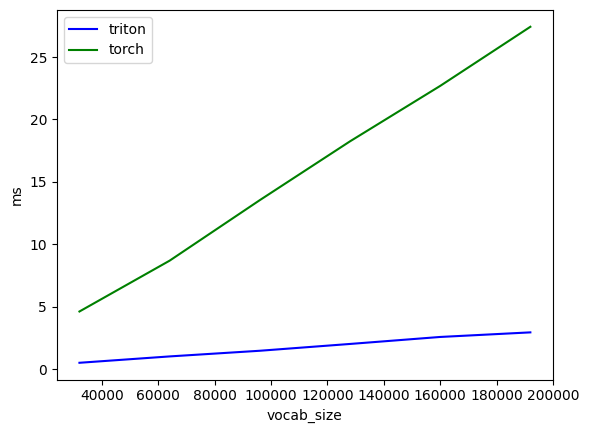

compute logp:
   vocab_size    triton      torch
0     32000.0  0.514511   4.622731
1     64000.0  1.024138   8.693873
2     96000.0  1.477454  13.541513
3    128000.0  2.022543  18.250278
4    160000.0  2.582751  22.690176
5    192000.0  2.950109  27.426208


In [8]:

@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['vocab_size'],  # argument names to use as an x-axis for the plot
        x_vals=[32000 + 16000 * i for i in range(0, 11, 2)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['triton', "torch"],  # possible values for `line_arg``
        line_names=[
            "triton",
            "torch",
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-'), ('orange', '-')],  # line styles
        ylabel="ms",  # label name for the y-axis
        plot_name="compute logp",  # name for the plot. Used also as a file name for saving the plot.
        args={'L': 2048, 'B': 16}
    ))
def benchmark(B, L, vocab_size, provider):
    device = "cuda"
    dtype = torch.bfloat16
    logits = torch.randn(B, L + 1, vocab_size, device=device, dtype=dtype)
    input_ids = torch.randint(0, vocab_size-1, (B, L + 100), dtype=torch.int64, device=device)
    mask = torch.ones(B, L+100, dtype=torch.int64, device=device)
    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)
    if provider == 'torch':
        ms = triton.testing.do_bench(lambda: selective_log_softmax(logits, input_ids))
    if provider == 'triton':
        ms = triton.testing.do_bench(lambda: fused_selective_log_softmax(logits, input_ids, mask=mask))
    return ms
benchmark.run(show_plots=True, print_data=True)


# grpo loss

## torch code

In [2]:

# 代码是根据trl仓库改的，因此triton实现也是根据这个仓库的实现方式进行改进的
# 最主要的就是p(x)和p_old(x)是一样的
def get_log_probs(logits, input_ids):
    per_token_logps = []
    for logits_row, input_ids_row in zip(logits, input_ids[:, -logits.size(1):]):
        log_probs = logits_row.log_softmax(dim=-1)
        token_log_prob = torch.gather(log_probs, dim=1, index=input_ids_row.unsqueeze(1)).squeeze(1)
        per_token_logps.append(token_log_prob)
    return torch.stack(per_token_logps)

def torch_grpo_loss(logits, old_logp, ref_logp, completion_ids, advantages, completion_mask, temperature, beta, eps_low, eps_high):
    assert logits.is_contiguous() and completion_ids.is_contiguous()
    assert old_logp is None or old_logp.is_contiguous()
    assert (ref_logp is not None and ref_logp.is_contiguous()) if beta != 0.0 else True
    logits = logits[:, :-1] # 错一位，对应下一个输入token的概率         
    per_token_logps = get_log_probs(logits / temperature, completion_ids) # logits是需要计算梯度，因此会保存中间结果log_probs
    # return per_token_logps, None, None
    ref_per_token_logps = ref_logp

    if old_logp is None:
        old_logp = per_token_logps.detach()
    coef_1 = torch.exp(per_token_logps - old_logp)
    coef_2 = torch.clamp(coef_1, 1 - eps_low, 1 + eps_high)
    per_token_loss1 = coef_1 * advantages.unsqueeze(1)
    per_token_loss2 = coef_2 * advantages.unsqueeze(1)
    per_token_loss = -torch.min(per_token_loss1, per_token_loss2)
    per_token_loss = per_token_loss * completion_mask if completion_mask is not None else per_token_loss

    per_token_kl = None
    if beta != 0.0:
        per_token_kl = torch.exp(ref_per_token_logps - per_token_logps) - (ref_per_token_logps - per_token_logps) - 1
        if completion_mask is not None:
            per_token_kl *= completion_mask
        per_token_loss = per_token_loss + beta * per_token_kl
    is_clipped = (per_token_loss1 < per_token_loss2).float()
    return per_token_loss, per_token_kl, is_clipped

## triton code

In [ ]:
# @triton.autotune([triton.Config({"BLOCK_N":BLOCK_N}, num_stages=ns, num_warps=nw)
#                   for BLOCK_N in [2048, 4096, 8192]
#                   for ns in [1, 2, 4]
#                   for nw in [1, 2, 4, 8, 16]],
#                   key=['N'])
@triton.jit
def _grpo_loss_fwd_kernel(LOGITS,
                         OLD_LOGP,
                         REF_LOGP,
                        INPUT_IDS,
                        COMPLETION_MASK,
                        ADVANTAGES,
                        LOSS,
                        LSE,
                        KL,
                        IS_CLIPPED,
                        TEMPERATURE,
                        BETA:tl.constexpr,
                        EPS_LOW,
                        EPS_HIGH,
                        L: tl.constexpr,
                        N: tl.constexpr,
                        BLOCK_N:tl.constexpr=4096):
    off_b = tl.program_id(0).cast(tl.int64)
    off_l = tl.program_id(1).cast(tl.int64)

    if COMPLETION_MASK is not None:
        COMPLETION_MASK += off_b * L + off_l
        not_skip = tl.load(COMPLETION_MASK)
        if not_skip == 0:
            return
        
    LOGITS += off_b * (L+1) * N + off_l * N
    INPUT_IDS += off_b * L + off_l
    ADVANTAGES += off_b
    LOSS += off_b * L + off_l
    LSE += off_b * L + off_l
    IS_CLIPPED += off_b * L + off_l
        
    m_i = float('-inf')
    l_i = 0. 
    for start in range(0, N, BLOCK_N):
        cols = start + tl.arange(0, BLOCK_N)
        logits = tl.load(LOGITS + cols, mask=cols < N, other=float('-inf')).to(tl.float32) / TEMPERATURE
        new_m_i = tl.maximum(m_i, tl.max(logits))
        alpha = tl.exp(m_i - new_m_i)
        l_i = l_i * alpha + tl.sum(tl.exp(logits - new_m_i))
        m_i = new_m_i
    lse = m_i + tl.log(l_i)

    idx = tl.load(INPUT_IDS)
    x = tl.load(LOGITS + idx).to(tl.float32) / TEMPERATURE
    logp = x - lse
    if OLD_LOGP is None:
        old_logp = logp
    else:
        OLD_LOGP += off_b * L + off_l
        old_logp = tl.load(OLD_LOGP).to(tl.float32)
    coef_1 = tl.exp(logp - old_logp)
    coef_2 = tl.clamp(coef_1, 1 - EPS_LOW, 1 + EPS_HIGH)
    advantage = tl.load(ADVANTAGES).to(tl.float32)
    per_token_loss1 = coef_1 * advantage
    per_token_loss2 = coef_2 * advantage
    per_token_loss = -tl.minimum(per_token_loss1, per_token_loss2)
    is_clipped = per_token_loss1 < per_token_loss2

    if BETA != 0.0:
        REF_LOGP += off_b * L + off_l
        KL += off_b * L + off_l
        ref_logp = tl.load(REF_LOGP).to(tl.float32)
        kl = tl.exp(ref_logp - logp) - (ref_logp - logp) - 1
        per_token_loss += BETA * kl
        tl.store(KL, kl)
        
    tl.store(LOSS, per_token_loss)
    tl.store(LSE, lse)
    tl.store(IS_CLIPPED, is_clipped)
    

# @triton.autotune([triton.Config({"BLOCK_N":BLOCK_N}, num_stages=ns, num_warps=nw)
#                   for BLOCK_N in [2048, 4096, 8192]
#                   for ns in [1, 2, 4]
#                   for nw in [1, 2, 4, 8, 16]],
#                   key=['N'])  
@triton.jit
def _grpo_loss_bwd_kernel(DLOSS,
                        DLOGITS,
                        LOGITS,
                         OLD_LOGP,
                         REF_LOGP,
                        INPUT_IDS,
                        ADVANTAGES,
                        COMPLETION_MASK,
                        LSE,
                        TEMPERATURE,
                        BETA:tl.constexpr,
                        EPS_LOW,
                        EPS_HIGH,
                        loss_stride0,
                        loss_stride1,
                        L: tl.constexpr,
                        N: tl.constexpr,
                        BLOCK_N:tl.constexpr=4096):

    off_b = tl.program_id(0).cast(tl.int64)
    off_l = tl.program_id(1).cast(tl.int64)

    
    DLOGITS += off_b * (L+1) * N + off_l * N
    if COMPLETION_MASK is not None:
        COMPLETION_MASK += off_b * L + off_l
        not_skip = tl.load(COMPLETION_MASK)
        if not_skip == 0:
            for start in range(0, N, BLOCK_N):
                cols = tl.arange(0, BLOCK_N) + start
                tl.store(DLOGITS+cols, 0., mask=cols<N)
            return
    
    LOGITS += off_b * (L+1) * N + off_l * N
    DLOSS += off_b * loss_stride0 + off_l * loss_stride1
    INPUT_IDS += off_b * L + off_l
    ADVANTAGES += off_b
    LSE += off_b * L + off_l

    dloss = tl.load(DLOSS).to(tl.float32)
    lse = tl.load(LSE).to(tl.float32)

    idx = tl.load(INPUT_IDS)
    x = tl.load(LOGITS + idx).to(tl.float32) / TEMPERATURE
    logp = x - lse
    if OLD_LOGP is None:
        old_logp = logp
    else:
        OLD_LOGP += off_b * L + off_l
        old_logp = tl.load(OLD_LOGP).to(tl.float32)
    coef_1 = tl.exp(logp - old_logp)
    coef_2 = tl.clamp(coef_1, 1 - EPS_LOW, 1 + EPS_HIGH)
    advantage = tl.load(ADVANTAGES).to(tl.float32)
    per_token_loss1 = coef_1 * advantage
    per_token_loss2 = coef_2 * advantage
    mask = per_token_loss2 >= per_token_loss1

    dlogp = -per_token_loss1 * mask
    if BETA != 0.0:
        REF_LOGP += off_b * L + off_l
        ref_logp = tl.load(REF_LOGP).to(tl.float32)
        dlogp += BETA * (1 - tl.exp(ref_logp - logp))
    
    dlogp = dlogp * dloss / TEMPERATURE
    
    for start_n in tl.range(0, N, BLOCK_N):
        cols = start_n + tl.arange(0, BLOCK_N)
        logits = tl.load(LOGITS+cols, mask=cols < N, other=-float('inf')).to(tl.float32) / TEMPERATURE
        probs = tl.exp(logits - lse)
        dlogits = tl.where(cols==idx, 1-probs, -probs) * dlogp
        tl.store(DLOGITS+cols, dlogits, mask=cols < N)
        

class GrpoLoss(torch.autograd.Function):
    @staticmethod
    def forward(ctx, logits, old_logp, ref_logp, completion_ids, advantages, completion_mask, temperature, beta, eps_low, eps_high, inplace):
        assert logits.is_contiguous() and completion_ids.is_contiguous()
        assert old_logp is None or old_logp.is_contiguous()
        assert (ref_logp is not None and ref_logp.is_contiguous()) if beta != 0.0 else True
        
        B, L_ADD_1, N = logits.shape
        L = L_ADD_1 - 1

        if completion_mask is not None:
            assert completion_mask.is_contiguous()

        loss = torch.zeros(B, L, device=logits.device, dtype=torch.float32)
        lse = torch.zeros_like(loss)
        is_clipped = torch.zeros_like(loss)
        kl = torch.zeros_like(loss) if beta != 0.0 else None
        kwargs = {"BLOCK_N":2048, "num_stages":2, "num_warps":1}
        _grpo_loss_fwd_kernel[(B, L)](logits,
                                     old_logp,
                                     ref_logp,
                                     completion_ids,
                                     completion_mask,
                                     advantages,
                                     loss,
                                     lse,
                                     kl,
                                     is_clipped,
                                     temperature,
                                     beta,
                                     eps_low,
                                     eps_high,
                                     L,
                                     N,
                                     **kwargs
                                     )
        ctx.save_for_backward(logits, old_logp, ref_logp, completion_ids, advantages, completion_mask, lse)
        ctx.infos = (temperature, beta, eps_low, eps_high, inplace)
        # return loss
        return loss, kl, is_clipped
    
    @staticmethod
    def backward(ctx, *args):
        dloss = args[0]
        # print(dloss.shape)
        logits, old_logp, ref_logp, completion_ids, advantages, completion_mask, lse = ctx.saved_tensors
        temperature, beta, eps_low, eps_high, inplace = ctx.infos
        B, L_ADD_1, N = logits.shape
        L = L_ADD_1 - 1
        dlogits = logits.data if inplace else torch.empty_like(logits)
        kwargs = {"BLOCK_N":4096, "num_stages":1, "num_warps":16}
        _grpo_loss_bwd_kernel[(B, L)](dloss,
                                      dlogits,
                                      logits,
                                      old_logp,
                                      ref_logp,
                                      completion_ids,
                                      advantages,
                                      completion_mask,
                                      lse,
                                      temperature,
                                      beta,
                                      eps_low,
                                      eps_high,
                                      *dloss.stride(),
                                      L,
                                      N,
                                      **kwargs
                                        )
        dlogits[:, -1, :] = 0
        return dlogits, None,None,None,None,None,None,None,None,None,None

def triton_grpo_loss(logits, 
                     old_logp, 
                     ref_logp, 
                     completion_ids, 
                     advantages, 
                     completion_mask=None, 
                     temperature=0.9, 
                     beta=0.04, 
                     eps_low=0.2, 
                     eps_high=0.4, 
                     inplace=True):
    assert logits is not None and completion_ids is not None and advantages is not None, "must provide logits、completion_ids and advantages"

    return GrpoLoss.apply(logits, 
                          old_logp, 
                          ref_logp, 
                          completion_ids, 
                          advantages, 
                          completion_mask, 
                          temperature, 
                          beta, 
                          eps_low, 
                          eps_high,
                          inplace)


## 精度

In [5]:
vocab_size = 12800
B, L = 8, 1024
device = "cuda"
dtype = torch.bfloat16
logits1 = torch.randn(B, L + 1, vocab_size, device=device, dtype=dtype)
logits1.requires_grad_(True)
logits2 = deepcopy(logits1)
gold_logits = logits1.detach().clone().float()
gold_logits.requires_grad_(True)

completion_ids = torch.randint(0, vocab_size-1, (B, L), dtype=torch.int64, device=device)
completion_mask = torch.ones_like(completion_ids, dtype=torch.int32)
completion_mask[:, -200:] = 0
completion_mask = None
ref_logp = torch.randn(B, L, device=device, dtype=torch.float32)
# ref_logp = None
old_logp = torch.randn(B, L, device=device, dtype=torch.float32)
# old_logp = None
advantages = torch.randn(B, device=device, dtype=torch.float32)
temperature, beta, eps_low, eps_high = 0.9, 0.1, 0.2, 0.4
inplace = True


In [64]:
loss1, kl1, is_clipped1 = torch_grpo_loss(logits1,
                old_logp,
                ref_logp,
                completion_ids,
                advantages,
                completion_mask,
                temperature,
                beta,
                eps_low,
                eps_high)

loss2, kl2, is_clipped2 = triton_grpo_loss(logits2,
                old_logp,
                ref_logp,
                completion_ids,
                advantages,
                completion_mask,
                temperature,
                beta,
                eps_low,
                eps_high,
                inplace)

gold_loss, gold_kl, gold_is_clipped = torch_grpo_loss(gold_logits,
                old_logp,
                ref_logp,
                completion_ids,
                advantages,
                completion_mask,
                temperature,
                beta,
                eps_low,
                eps_high)
dy = torch.randn_like(loss1)
loss1.backward(dy)
loss2.backward(dy)
gold_loss.backward(dy)
print("torch-bf16 vs torch-fp32")
compare(loss1, gold_loss)
compare(kl1, gold_kl)
compare(logits1.grad, gold_logits.grad)
print("triton-bf16 vs torch-fp32")
compare(loss2, gold_loss)
compare(kl2, gold_kl)
compare(logits2.grad, gold_logits.grad)

torch.bfloat16
tensor([[ 1.5078, -0.7812, -0.0031,  ...,  0.0947,  0.3262, -1.7109],
        [-1.8594,  0.3145,  0.9492,  ..., -0.1846,  0.3457, -0.2500],
        [ 1.4688,  1.3438,  1.2656,  ..., -1.3672, -1.2031,  0.8594],
        ...,
        [ 1.1328, -0.1641,  0.8945,  ...,  0.4062, -2.6250,  0.0981],
        [ 2.9219, -1.2031, -0.9141,  ...,  0.2988,  1.0312,  0.3906],
        [ 1.0547,  0.7031,  0.8984,  ...,  1.2578, -0.8008,  0.3906]],
       device='cuda:0', dtype=torch.bfloat16)
torch-bf16 vs torch-fp32
最大差异: 0.03717529773712158, 平均差异: 0.015210638754069805
最大差异: 0.0371752567589283, 平均差异: 0.01521728653460741
最大差异: 0.07416863739490509, 平均差异: 0.020347652956843376
triton-bf16 vs torch-fp32
最大差异: 2.5674696644273354e-06, 平均差异: 4.94974187859043e-07
最大差异: 2.6141508442378836e-06, 平均差异: 4.927860572934151e-07
最大差异: 0.003892687149345875, 平均差异: 0.001402462599799037


In [16]:
print(triton.testing.do_bench(lambda:torch_grpo_loss(logits1,
                old_logp,
                ref_logp,
                completion_ids,
                advantages,
                completion_mask,
                temperature,
                beta,
                eps_low,
                eps_high)[0].sum().backward()))

print(triton.testing.do_bench(lambda:triton_grpo_loss(logits2,
                old_logp,
                ref_logp,
                completion_ids,
                advantages,
                completion_mask,
                temperature,
                beta,
                eps_low,
                eps_high)[0].sum().backward()))

16.847122192382812
2.879578113555908


## 速度

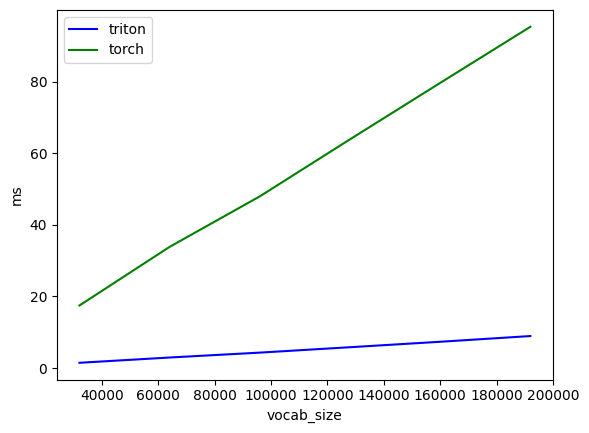

GRPO LOSS:
   vocab_size    triton      torch
0     32000.0  1.496177  17.489887
1     64000.0  2.967113  33.858929
2     96000.0  4.331829  47.953056
3    128000.0  5.840693  63.874176
4    160000.0  7.363397  79.620605
5    192000.0  8.956139  95.290466


In [5]:

@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['vocab_size'],  # argument names to use as an x-axis for the plot
        x_vals=[32000 + 16000 * i for i in range(0, 11, 2)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['triton', "torch"],  # possible values for `line_arg``
        line_names=[
            "triton",
            "torch",
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-'), ('orange', '-')],  # line styles
        ylabel="ms",  # label name for the y-axis
        plot_name="GRPO LOSS",  # name for the plot. Used also as a file name for saving the plot.
        args={'L': 2048, 'B': 16}
    ))
def benchmark(B, L, vocab_size, provider):
    device = "cuda"
    dtype = torch.bfloat16
    logits = torch.randn(B, L + 1, vocab_size, device=device, dtype=dtype)
    logits.requires_grad_(True)
    completion_ids = torch.randint(0, vocab_size-1, (B, L), dtype=torch.int64, device=device)
    completion_mask = torch.ones_like(completion_ids, dtype=torch.int32)
    completion_mask[:, -200:] = 0
    ref_logp = torch.randn(B, L, device=device, dtype=torch.float32)
    old_logp = torch.randn(B, L, device=device, dtype=torch.float32)
    advantages = torch.randn(B, device=device, dtype=torch.float32)
    temperature, beta, eps_low, eps_high = 0.9, 0.1, 0.2, 0.4
    # dy = torch.randn(B, L, device=device, dtype=torch.float32)
    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)
    if provider == 'torch':
        ms = triton.testing.do_bench(lambda: torch_grpo_loss(logits,
                old_logp,
                ref_logp,
                completion_ids,
                advantages,
                completion_mask,
                temperature,
                beta,
                eps_low,
                eps_high)[0].sum().backward(), grad_to_none=[logits])
    if provider == 'triton':
        ms = triton.testing.do_bench(lambda: triton_grpo_loss(logits,
                old_logp,
                ref_logp,
                completion_ids,
                advantages,
                completion_mask,
                temperature,
                beta,
                eps_low,
                eps_high)[0].sum().backward(), grad_to_none=[logits])
    return ms
benchmark.run(show_plots=True, print_data=True)


## 显存

In [4]:
vocab_size = 151936
B, L = 16, 2048
device = "cuda"
dtype = torch.bfloat16
logits = torch.randn(B, L + 1, vocab_size, device=device, dtype=dtype)
logits.requires_grad_(True)

completion_ids = torch.randint(0, vocab_size-1, (B, L), dtype=torch.int64, device=device)
completion_mask = None
ref_logp = torch.randn(B, L, device=device, dtype=torch.float32)
# ref_logp = None
old_logp = torch.randn(B, L, device=device, dtype=torch.float32)
# old_logp = None
dy = torch.randn_like(ref_logp)
advantages = torch.randn(B, device=device, dtype=torch.float32)
temperature, beta, eps_low, eps_high = 0.9, 0.1, 0.5, 1.5
time.sleep(5)

for _ in tqdm(range(50)):
    loss = torch_grpo_loss(logits,
                old_logp,
                ref_logp,
                completion_ids,
                advantages,
                completion_mask,
                temperature,
                beta,
                eps_low,
                eps_high)[0]
    loss.backward(dy)
    logits.grad = None
# 10 -> 10
# 10 -> 56

100%|██████████| 50/50 [00:03<00:00, 13.54it/s]


In [ ]:
logits = logits / temperature
logits_softmax = F.softmax(logits, -1)
logp = torch.gather(logits_softmax, -1, completion_ids.unsqueeze(-1)).squeeze(-1)
logp.backward(old_logp)

# 训练模拟

In [4]:
def zero_grad(model:torch.nn.Module):
    for p in model.parameters():
        torch.optim.AdamW
        p.grad = None
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
set_seed(42)

In [ ]:
device = "cuda"
dtype = torch.bfloat16

B, L = 16, 2048
vocab_size = 151936

input_ids = torch.randint(0, vocab_size-1, (B, L+100), dtype=torch.int64, device=device)
completion_ids = input_ids[:, -L:].contiguous()
advantages = torch.randn(B, device=device, dtype=torch.float32)
ref_logp = torch.randn(B, L, device=device, dtype=torch.float32)
old_logp = torch.randn(B, L, device=device, dtype=torch.float32)
completion_mask = torch.ones_like(completion_ids, dtype=torch.int32)
completion_mask[:, -200:] = 0
temperature, beta, eps_low, eps_high = 0.9, 0.1, 0.2, 0.4

model_path = "/sharedata/mdy/models/DeepSeek-R1-Distill-Qwen-1.5B"
# model = AutoModelForCausalLM.from_pretrained(model_path, torch_dtype=torch.bfloat16, device_map="cuda")
config = AutoConfig.from_pretrained(model_path)
config._attn_implementation = "flash_attention_2"
config.num_hidden_layers = 2
model = Qwen2ForCausalLM(config).to(dtype).to(device)

In [ ]:
model.train()
for _ in tqdm(range(20)):
    # torch.cuda.empty_cache()
    zero_grad(model)
    logits = model(input_ids, logits_to_keep=L+1).logits
    per_token_loss = triton_grpo_loss(logits,
                    old_logp,
                    ref_logp,
                    completion_ids,
                    advantages,
                    completion_mask,
                    temperature,
                    beta,
                    eps_low,
                    eps_high)[0]
    loss = (per_token_loss * completion_mask).sum() / completion_mask.sum()
    loss.backward()

100%|██████████| 20/20 [00:03<00:00,  5.87it/s]


# grad of clamp op

In [2]:
import torch
import copy

In [3]:
class _Clamp(torch.autograd.Function):
    @staticmethod
    def forward(ctx, coef_1, advantages, low, high):
        coef_2 = copy.deepcopy(coef_1)
        coef_2[coef_1<low] = low
        coef_2[coef_1>high] = high
        per_token_loss1 = coef_1 * advantages.unsqueeze(1)
        per_token_loss2 = coef_2 * advantages.unsqueeze(1)
        per_token_loss = -torch.min(per_token_loss1, per_token_loss2)
        # min操作选取的不是coef_2被截断的部分，梯度是正常的，其他为0
        mask = per_token_loss1 <= per_token_loss2
        ctx.save_for_backward(mask, advantages)
        return per_token_loss
    
    @staticmethod
    def backward(ctx, dloss:torch.Tensor):
        mask, advantages = ctx.saved_tensors
        dgrad = -dloss * advantages.unsqueeze(1) * mask
        return dgrad, None, None, None

def my_clamp(coef_1, advantages, low, high):
    return _Clamp.apply(coef_1, advantages, low, high)

def offical_clamp(coef_1, advantages, low, high):
    coef_2 = torch.clamp(coef_1, low, high)
    per_token_loss1 = coef_1 * advantages.unsqueeze(1)
    per_token_loss2 = coef_2 * advantages.unsqueeze(1)
    per_token_loss = -torch.min(per_token_loss1, per_token_loss2)
    return per_token_loss


In [4]:
coef_1 = torch.randn(64,64)
coef_1.requires_grad_(True)
coef_1_copy = copy.deepcopy(coef_1)
dy = torch.randn_like(coef_1)
low = -1
high = 1
advantages = torch.randn(64)


In [5]:
loss1 = offical_clamp(coef_1, advantages, low, high)
loss2 = my_clamp(coef_1_copy, advantages, low, high)
loss1.backward(dy)
loss2.backward(dy)
print(torch.allclose(loss1, loss2))
print(torch.allclose(coef_1.grad, coef_1_copy.grad))

True
True
